In [152]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

In [153]:
page = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
soup = BeautifulSoup(page.text, 'html.parser')

In [154]:
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))

In [155]:
new_df=df[0]

In [156]:
new_df.columns = new_df.iloc[0]


In [157]:
df = new_df.drop(new_df.index[0])
df.head()


,Postcode,Borough,Neighbourhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront


# Ignore rows which are having Borough as "Not Assigned"

In [158]:
df =df[df.Borough != 'Not assigned']
df['Borough'].unique

<bound method Series.unique of 3            North York
4            North York
5      Downtown Toronto
6      Downtown Toronto
7            North York
8            North York
9          Queen's Park
11            Etobicoke
12          Scarborough
13          Scarborough
15           North York
16            East York
17            East York
18     Downtown Toronto
19     Downtown Toronto
20           North York
23            Etobicoke
24            Etobicoke
25            Etobicoke
26            Etobicoke
27            Etobicoke
28          Scarborough
29          Scarborough
30          Scarborough
32           North York
33           North York
34            East York
35     Downtown Toronto
36                 York
39            Etobicoke
             ...       
237         Scarborough
238         Scarborough
241    Downtown Toronto
242    Downtown Toronto
245           Etobicoke
246           Etobicoke
247           Etobicoke
248         Scarborough
251    Downtown Toronto
252    Do

# Combine duplicate Neighbourhood into single rows

In [159]:
df=df.groupby([df.Postcode,df.Borough],as_index=False).agg(', '.join)
df = df.rename(columns={'Postcode': 'Postal Code'})
df.head()

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [160]:
df.loc[df.Neighbourhood=='Not assigned']

,Postal Code,Borough,Neighbourhood
85,M7A,Queen's Park,Not assigned


# Copying Borough information to Neighbourhood, if Neighbourhood is "Not Assigned"

In [161]:
df['Neighbourhood'] = np.where(df['Neighbourhood']=='Not assigned', df['Borough'], df['Neighbourhood'])


In [162]:
df.shape

(103, 3)

In [163]:
df.loc[df['Postal Code']=='M7A']

,Postal Code,Borough,Neighbourhood
85,M7A,Queen's Park,Queen's Park


In [164]:
# The code was removed by Watson Studio for sharing.

,Latitude,Longitude
Postal Code,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


# I tried Geopy and got some inconsistent results every time and time out errors. So, went ahead and pulled the CSV file with lat lon values as suggested in the exercise

# Making the original dataframe postal code as index for merging with the data frame coming from coursera for lat and longitude

In [165]:
df.set_index('Postal Code',inplace=True)
df.head()

,Borough,Neighbourhood
Postal Code,,
M1B,Scarborough,"Rouge, Malvern"
M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
M1E,Scarborough,"Guildwood, Morningside, West Hill"
M1G,Scarborough,Woburn
M1H,Scarborough,Cedarbrae


In [166]:
df=df.join(ldf)

In [167]:
df.head()

,Borough,Neighbourhood,Latitude,Longitude
Postal Code,,,,
M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
M1G,Scarborough,Woburn,43.770992,-79.216917
M1H,Scarborough,Cedarbrae,43.773136,-79.239476


<function matplotlib.pyplot.show>

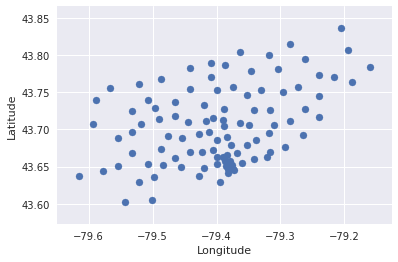

In [168]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
plt.scatter(df['Longitude'],df['Latitude'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show


# Cluster Analysis

In [169]:
x = df[['Longitude','Latitude']]
from sklearn import preprocessing

# scale the data for better results
x_scaled = preprocessing.scale(x)


In [170]:
from sklearn.cluster import KMeans

kmeans = KMeans(7)
kmeans.fit(x_scaled)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

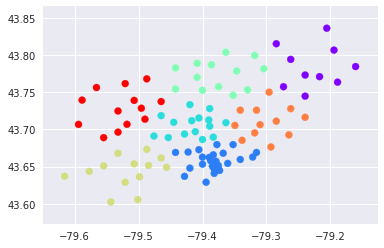

In [171]:
cluster_scaled = df.copy()
cluster_scaled['predict'] = kmeans.fit_predict(x_scaled)
plt.scatter(cluster_scaled['Longitude'], cluster_scaled['Latitude'], c= cluster_scaled ['predict'], cmap = 'rainbow')


# WCSS Computation and Elbow evaluation

In [172]:
wcss = []
cl_num = 15

for i in range(1,cl_num):
    kmeans = KMeans(i)
    kmeans.fit(x_scaled)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)


Text(0.5,0,'no of clusters')

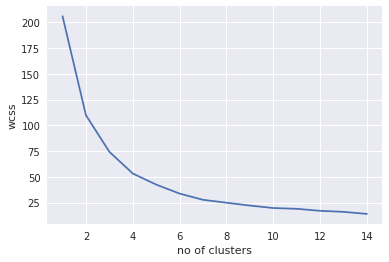

In [173]:
plt.plot(range(1,15),wcss)
plt.show
plt.ylabel('wcss')
plt.xlabel('no of clusters')

# Map Visualization

In [174]:
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab

import folium

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge


In [175]:
latitude =43.7
longitude = -79.383
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat,lan,borough in zip(df.Latitude,df.Longitude,df.Borough):
    
    label = '{}, {}, {}'.format(lat,lan,borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lan],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
map_toronto

# Foursquare API Calls 

In [176]:
CLIENT_ID = 'IYUYZGQ1MKKUXRYJVYPIDLZ5OHJ0FZH0EW43ZDS554AJCIUB' # your Foursquare ID
CLIENT_SECRET = '3X3UA3W0VYCYVLM1LD2KP03E2J1RI4YL3BVGD0SYEWVTWFOM' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IYUYZGQ1MKKUXRYJVYPIDLZ5OHJ0FZH0EW43ZDS554AJCIUB
CLIENT_SECRET:3X3UA3W0VYCYVLM1LD2KP03E2J1RI4YL3BVGD0SYEWVTWFOM


# Taking only Toronto Boroughs

In [177]:
df.head()

,Borough,Neighbourhood,Latitude,Longitude
Postal Code,,,,
M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
M1G,Scarborough,Woburn,43.770992,-79.216917
M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [178]:
def get_100_venues(borough_latitude,borough_longitude):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    borough_latitude, 
    borough_longitude, 
    radius, 
    LIMIT)
    return url # display URL

In [179]:
url =get_100_venues(43.676357,-79.293031)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=IYUYZGQ1MKKUXRYJVYPIDLZ5OHJ0FZH0EW43ZDS554AJCIUB&client_secret=3X3UA3W0VYCYVLM1LD2KP03E2J1RI4YL3BVGD0SYEWVTWFOM&v=20180604&ll=43.676357,-79.293031&radius=500&limit=100'

In [180]:
def get_category(row):
    
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [181]:
results = requests.get(url).json()
venues=results['response']['groups'][0]['items']
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
nearby_venues = json_normalize(venues) # flatten JSON
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues

#nearby_venues['venue.location.lat','venue.location.lng']

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,The Big Carrot Natural Food Market,"[{'shortName': 'Health Food Store', 'id': '50a...",43.678879,-79.297734
1,Grover Pub and Grub,"[{'shortName': 'Pub', 'id': '4bf58dd8d48988d11...",43.679181,-79.297215
2,Starbucks,"[{'shortName': 'Coffee Shop', 'id': '4bf58dd8d...",43.678798,-79.298045
3,Upper Beaches,"[{'shortName': 'Neighborhood', 'id': '4f2a25ac...",43.680563,-79.292869


In [182]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category, axis=1)
nearby_venues.columns = [ x.split('.')[-1] for x in nearby_venues.columns]
nearby_venues

,name,categories,lat,lng
0,The Big Carrot Natural Food Market,Health Food Store,43.678879,-79.297734
1,Grover Pub and Grub,Pub,43.679181,-79.297215
2,Starbucks,Coffee Shop,43.678798,-79.298045
3,Upper Beaches,Neighborhood,43.680563,-79.292869


In [183]:
venues_list = []
for borough,lat,lon in zip(df.Borough,df.Latitude,df.Longitude):
    url =get_100_venues(lat,lon)
    results = requests.get(url).json()["response"]['groups'][0]['items']
    venues_list.append([(
        borough,
        lat,
        lon,
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])
    print ("Doing for {}".format (borough))
venue_df = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
venue_df.columns = ['Borough Name','Borough Lat','Borough Lon','Venue Name','Venue Lat','Venue Lon','Venue Cat']
venue_df.head()

Doing for Scarborough
Doing for Scarborough
Doing for Scarborough
Doing for Scarborough
Doing for Scarborough
Doing for Scarborough
Doing for Scarborough
Doing for Scarborough
Doing for Scarborough
Doing for Scarborough
Doing for Scarborough
Doing for Scarborough
Doing for Scarborough
Doing for Scarborough
Doing for Scarborough
Doing for Scarborough
Doing for Scarborough
Doing for North York
Doing for North York
Doing for North York
Doing for North York
Doing for North York
Doing for North York
Doing for North York
Doing for North York
Doing for North York
Doing for North York
Doing for North York
Doing for North York
Doing for North York
Doing for North York
Doing for North York
Doing for North York
Doing for North York
Doing for North York
Doing for East York
Doing for East York
Doing for East Toronto
Doing for East York
Doing for East York
Doing for East York
Doing for East Toronto
Doing for East Toronto
Doing for East Toronto
Doing for Central Toronto
Doing for Central Toronto
Doin

,Borough Name,Borough Lat,Borough Lon,Venue Name,Venue Lat,Venue Lon,Venue Cat
0,Scarborough,43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,Scarborough,43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
2,Scarborough,43.784535,-79.160497,RIGHT WAY TO GOLF,43.785177,-79.161108,Golf Course
3,Scarborough,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
4,Scarborough,43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place


In [109]:
venue_df.shape

(1693, 7)

In [191]:
venue_df_hot = pd.get_dummies(venue_df[['Venue Cat']], prefix="", prefix_sep="")
venue_df_hot['Borough Name'] = venue_df['Borough Name']
fixed_columns = [venue_df.columns[0]] + list(venue_df_hot.columns[:-1])
venue_df_hot = venue_df_hot[fixed_columns]
venue_df_hot[venue_df_hot['Borough Name']=='Central Toronto']

,Borough Name,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
459,Central Toronto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
460,Central Toronto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
461,Central Toronto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
462,Central Toronto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
463,Central Toronto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
464,Central Toronto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
465,Central Toronto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
466,Central Toronto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
467,Central Toronto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
468,Central Toronto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [192]:
venue_df_hot_grouped = venue_df_hot.groupby('Borough Name').sum().reset_index()
venue_df_hot_grouped

,Borough Name,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Central Toronto,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
1,Downtown Toronto,0,1,1,1,1,1,2,2,2,...,0,10,3,0,7,0,8,1,3,4
2,East Toronto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
3,East York,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
4,Etobicoke,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,Mississauga,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,North York,1,0,0,1,0,0,0,0,0,...,0,0,1,1,2,0,0,1,3,0
7,Queen's Park,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
8,Scarborough,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9,West Toronto,0,0,0,0,0,0,0,0,0,...,0,2,0,0,2,0,1,0,0,1


In [193]:
venue_df_hot_grouped['Borough Name']

0      Central Toronto
1     Downtown Toronto
2         East Toronto
3            East York
4            Etobicoke
5          Mississauga
6           North York
7         Queen's Park
8          Scarborough
9         West Toronto
10                York
Name: Borough Name, dtype: object

In [194]:
borough_list = venue_df_hot_grouped['Borough Name']
top_ten_list =[]
for borough in borough_list:

    temp = venue_df_hot_grouped[venue_df_hot_grouped['Borough Name']==borough].T.reset_index()
    temp.columns=['Borough','Frequency']
    temp = temp.iloc[1:]
    temp.sort_values('Frequency',ascending=False,inplace=True)
    top_ten_list.append(["{} ({})" .format(t[0],t[1]) for t in temp[:10].values])
top_ten_list
df_top_ten = pd.DataFrame(top_ten_list)
df_top_ten.columns = ['#1 Favourite','#2 Favourite','#3 Favourite','#4 Favourite','#5 Favourite','#6 Favourite','#7 Favourite','#8 Favourite','#9Favourite','#10 Favourite',]
df_top_ten.set_index(borough_list,inplace=True)
df_top_ten.reset_index()

,Borough Name,#1 Favourite,#2 Favourite,#3 Favourite,#4 Favourite,#5 Favourite,#6 Favourite,#7 Favourite,#8 Favourite,#9Favourite,#10 Favourite
0,Central Toronto,Coffee Shop (9),Sandwich Place (8),Pizza Place (8),Café (5),Park (5),Dessert Shop (4),Sushi Restaurant (4),Pharmacy (3),Sporting Goods Shop (3),Burger Joint (3)
1,Downtown Toronto,Coffee Shop (119),Café (75),Restaurant (48),Hotel (40),Bakery (33),Italian Restaurant (29),Japanese Restaurant (26),Bar (25),American Restaurant (22),Pizza Place (20)
2,East Toronto,Greek Restaurant (10),Coffee Shop (8),Italian Restaurant (5),Ice Cream Shop (5),Brewery (4),Café (4),Yoga Studio (3),Park (3),Sandwich Place (3),Pub (3)
3,East York,Coffee Shop (5),Park (4),Burger Joint (3),Sporting Goods Shop (3),Pizza Place (3),Pharmacy (3),Bank (3),Grocery Store (3),Pet Store (2),Intersection (2)
4,Etobicoke,Pizza Place (8),Sandwich Place (5),Coffee Shop (4),Pharmacy (4),Fast Food Restaurant (3),Grocery Store (3),Gym (3),Beer Store (2),Bakery (2),Flower Shop (2)
5,Mississauga,Hotel (2),Coffee Shop (2),Mediterranean Restaurant (1),Fried Chicken Joint (1),Burrito Place (1),American Restaurant (1),Sandwich Place (1),Miscellaneous Shop (0),Middle Eastern Restaurant (0),Mexican Restaurant (0)
6,North York,Coffee Shop (16),Clothing Store (15),Fast Food Restaurant (11),Grocery Store (8),Japanese Restaurant (7),Restaurant (6),Pizza Place (6),Café (5),Bank (5),Shopping Mall (5)
7,Queen's Park,Coffee Shop (10),Sushi Restaurant (2),Gym (2),Diner (2),Japanese Restaurant (2),Restaurant (1),Sandwich Place (1),General Entertainment (1),Chinese Restaurant (1),Bar (1)
8,Scarborough,Pizza Place (5),Fast Food Restaurant (5),Coffee Shop (5),Chinese Restaurant (5),Breakfast Spot (4),Bakery (4),Sandwich Place (3),Skating Rink (3),Indian Restaurant (2),Thai Restaurant (2)
9,West Toronto,Bar (13),Coffee Shop (10),Café (10),Italian Restaurant (6),Pizza Place (6),Bakery (5),Restaurant (4),Music Venue (4),Men's Store (4),Breakfast Spot (4)


In [214]:
# set number of clusters
kclusters = 3

venue_grouped_clustering = venue_df_hot_grouped.drop('Borough Name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venue_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


array([0, 1, 0, 0, 0, 0, 2, 0, 0, 0], dtype=int32)

In [202]:
wcss = []
cl_num = 10

for i in range(1,cl_num):
    kmeans = KMeans(i)
    kmeans.fit(venue_grouped_clustering)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

Text(0.5,0,'no of clusters')

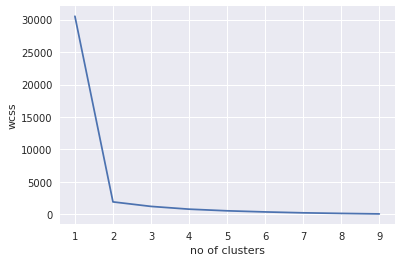

In [203]:
plt.plot(range(1,10),wcss)
plt.show
plt.ylabel('wcss')
plt.xlabel('no of clusters')

In [ ]:
df_top_ten.insert(0,'Cluster Label',kmeans.labels_)

# Cluster Label with 1

In [226]:
df_top_ten[df_top_ten['Cluster Label']==1]

,Cluster Label,#1 Favourite,#2 Favourite,#3 Favourite,#4 Favourite,#5 Favourite,#6 Favourite,#7 Favourite,#8 Favourite,#9Favourite,#10 Favourite
Borough Name,,,,,,,,,,,
Downtown Toronto,1,Coffee Shop (119),Café (75),Restaurant (48),Hotel (40),Bakery (33),Italian Restaurant (29),Japanese Restaurant (26),Bar (25),American Restaurant (22),Pizza Place (20)


# Cluster Label with 2

In [227]:
df_top_ten[df_top_ten['Cluster Label']==2]

,Cluster Label,#1 Favourite,#2 Favourite,#3 Favourite,#4 Favourite,#5 Favourite,#6 Favourite,#7 Favourite,#8 Favourite,#9Favourite,#10 Favourite
Borough Name,,,,,,,,,,,
North York,2,Coffee Shop (16),Clothing Store (15),Fast Food Restaurant (11),Grocery Store (8),Japanese Restaurant (7),Restaurant (6),Pizza Place (6),Café (5),Bank (5),Shopping Mall (5)


# Cluster Label with 0

In [228]:
df_top_ten[df_top_ten['Cluster Label']==0]

,Cluster Label,#1 Favourite,#2 Favourite,#3 Favourite,#4 Favourite,#5 Favourite,#6 Favourite,#7 Favourite,#8 Favourite,#9Favourite,#10 Favourite
Borough Name,,,,,,,,,,,
Central Toronto,0,Coffee Shop (9),Sandwich Place (8),Pizza Place (8),Café (5),Park (5),Dessert Shop (4),Sushi Restaurant (4),Pharmacy (3),Sporting Goods Shop (3),Burger Joint (3)
East Toronto,0,Greek Restaurant (10),Coffee Shop (8),Italian Restaurant (5),Ice Cream Shop (5),Brewery (4),Café (4),Yoga Studio (3),Park (3),Sandwich Place (3),Pub (3)
East York,0,Coffee Shop (5),Park (4),Burger Joint (3),Sporting Goods Shop (3),Pizza Place (3),Pharmacy (3),Bank (3),Grocery Store (3),Pet Store (2),Intersection (2)
Etobicoke,0,Pizza Place (8),Sandwich Place (5),Coffee Shop (4),Pharmacy (4),Fast Food Restaurant (3),Grocery Store (3),Gym (3),Beer Store (2),Bakery (2),Flower Shop (2)
Mississauga,0,Hotel (2),Coffee Shop (2),Mediterranean Restaurant (1),Fried Chicken Joint (1),Burrito Place (1),American Restaurant (1),Sandwich Place (1),Miscellaneous Shop (0),Middle Eastern Restaurant (0),Mexican Restaurant (0)
Queen's Park,0,Coffee Shop (10),Sushi Restaurant (2),Gym (2),Diner (2),Japanese Restaurant (2),Restaurant (1),Sandwich Place (1),General Entertainment (1),Chinese Restaurant (1),Bar (1)
Scarborough,0,Pizza Place (5),Fast Food Restaurant (5),Coffee Shop (5),Chinese Restaurant (5),Breakfast Spot (4),Bakery (4),Sandwich Place (3),Skating Rink (3),Indian Restaurant (2),Thai Restaurant (2)
West Toronto,0,Bar (13),Coffee Shop (10),Café (10),Italian Restaurant (6),Pizza Place (6),Bakery (5),Restaurant (4),Music Venue (4),Men's Store (4),Breakfast Spot (4)
York,0,Park (2),Hockey Arena (1),Trail (1),Field (1),Convenience Store (1),Fast Food Restaurant (1),Market (1),Bus Line (1),Sandwich Place (1),Coffee Shop (1)
